
source: https://github.com/bnsreenu/python_for_microscopists/blob/master/181_multivariate_timeseries_LSTM_GE.py



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

with open('/content/drive/My Drive/foo.txt', 'w') as f:
  f.write('Hello Google Drive!')
!cat /content/drive/My\ Drive/foo.txt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Hello Google Drive!

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
sns.set(rc={'figure.figsize':(12.5,6)})
sns.set_theme(style='whitegrid')

In [ ]:
#load data from folder
filepath = 'drive/My Drive/MSc WIN/05_HS2020/VMAT/Data/final_df.csv'
df=pd.read_csv(filepath)
df=df[['Date','shelter','temp_min','overlap_wo_shelter','pfuusbus_commuters','weekend','payday','holiday_bool']]
df=df[1:]
df.head()

,Date,shelter,temp_min,overlap_wo_shelter,pfuusbus_commuters,weekend,payday,holiday_bool
1,2012-05-21,55,11.10,59.0,0.0,0,0,0
2,2012-05-22,50,13.33,59.0,0.0,0,1,0
3,2012-05-23,53,15.00,59.0,0.0,0,1,0
4,2012-05-24,53,15.00,59.0,0.0,0,1,0
5,2012-05-25,52,15.56,59.0,0.0,1,0,0


In [ ]:
#Separate dates for future plotting
dates = pd.to_datetime(df['Date'])
train_dates = dates[:2031]
test_dates = dates[2032:]

#Variables for training
cols = list(df)[1:8]

df_for_training = df[cols].astype(float)

#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalized the dataset
scaler = MinMaxScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [ ]:
# split into train and test sets
train_size = int(len(df_for_training_scaled) * 0.8)
test_size = len(df_for_training_scaled) - train_size
train, test = df_for_training_scaled[0:train_size,:], df_for_training_scaled[train_size:len(df_for_training_scaled),:]

In [ ]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 2. We will make timesteps = 3. 
#With this, the resultant n_samples is 5 (as the input data has 9 rows).
trainX = []
trainY = []
testX = []
testY = []

n_future = 1   # Number of days we want to predict into the future
n_past = 14     # Number of past days we want to use to predict the future

for i in range(n_past, len(train) - n_future +1):
    trainY.append(train[i + n_future - 1:i + n_future, 0])
    trainX.append(train[i - n_past:i, 0:train.shape[1]])


for i in range(n_past, len(test) - n_future +1):  
    testX.append(test[i - n_past:i, 0:test.shape[1]])
    testY.append(test[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)
testX, testY = np.array(testX), np.array(testY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))
print('testX shape == {}.'.format(testX.shape))
print('testY shape == {}.'.format(testY.shape))

trainX shape == (2464, 14, 7).
trainY shape == (2464, 1).
testX shape == (606, 14, 7).
testY shape == (606, 1).


In [ ]:
# define Autoencoder model
model = Sequential()
model.add(LSTM(10, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(10, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mae')
model.summary()


# fit model
history = model.fit(trainX, trainY, epochs=40, batch_size=16, verbose=1)

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_64 (LSTM)               (None, 14, 10)            720       
_________________________________________________________________
lstm_65 (LSTM)               (None, 10)                840       
_________________________________________________________________
dropout_32 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 11        
Total params: 1,571
Trainable params: 1,571
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
154/154 [==============================] - 2s 6ms/step - loss: 0.2538
Epoch 2/40
154/154 [==============================] - 1s 6ms/step - loss: 0.1299
Epoch 3/40
154/154 [==============================] - 1s 6ms/step - loss: 0.1050
Epoch 

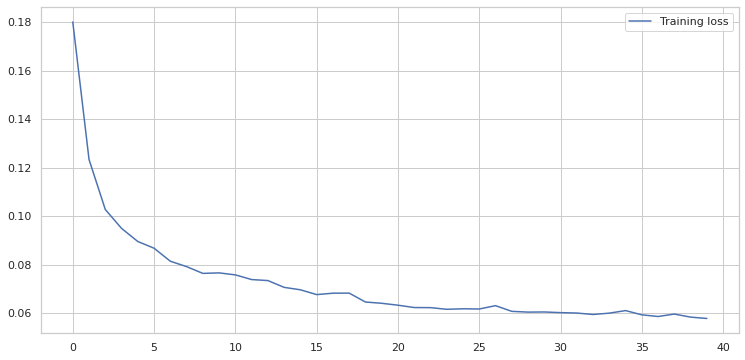

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
#plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [ ]:
#predict on validation set
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

#bring in correct shape and do inverse Scaling 
forecast_copies = np.repeat(testPredict, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]
y_pred_future

testY_copies = np.repeat(testY, df_for_training.shape[1], axis=-1)
testY = scaler.inverse_transform(testY_copies)[:,0]

MAE:  2.524911
MAPE:  11.872368


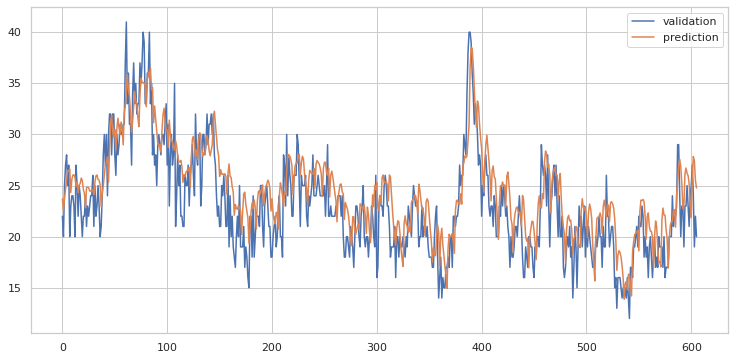

In [ ]:
#visalize full prediction and validation curve
plt.plot(testY,label='validation')
plt.plot(y_pred_future,label='prediction')
plt.legend()

import tensorflow as tf
print('MAE: ',tf.keras.metrics.mean_absolute_error(testY, y_pred_future).numpy().mean())
print('MAPE: ',tf.keras.metrics.mean_absolute_percentage_error(testY, y_pred_future).numpy().mean())

MAE:  2.6305077
MAPE:  11.056116


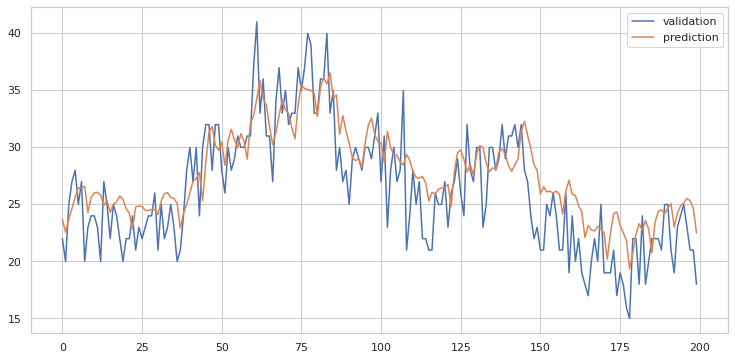

In [ ]:
# zoom in prediction and validation curve
plt.plot(testY[:200],label='validation')
plt.plot(y_pred_future[:200],label='prediction')
plt.legend()

import tensorflow as tf
print('MAE: ',tf.keras.metrics.mean_absolute_error(testY[:200], y_pred_future[:200]).numpy().mean())
print('MAPE: ',tf.keras.metrics.mean_absolute_percentage_error(testY[:200], y_pred_future[:200]).numpy().mean())

MAE:  2.453136
MAPE:  11.544173


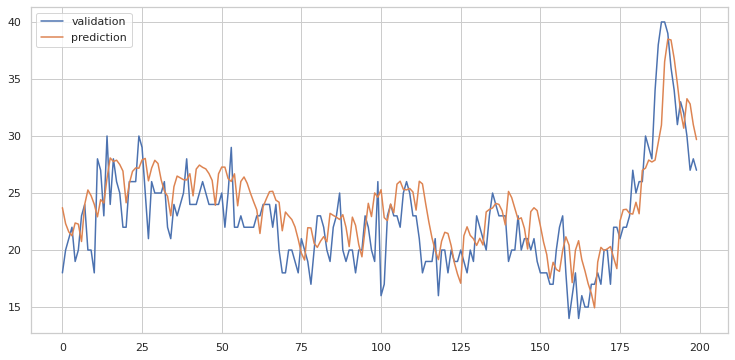

In [ ]:
plt.plot(testY[200:400],label='validation')
plt.plot(y_pred_future[200:400],label='prediction')
plt.legend()

import tensorflow as tf
print('MAE: ',tf.keras.metrics.mean_absolute_error(testY[200:400], y_pred_future[200:400]).numpy().mean())
print('MAPE: ',tf.keras.metrics.mean_absolute_percentage_error(testY[200:400], y_pred_future[200:400]).numpy().mean())

MAE:  2.453136
MAPE:  11.544173


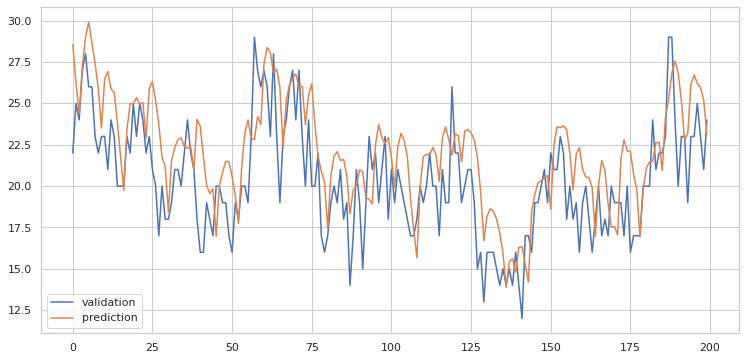

In [ ]:
plt.plot(testY[400:600],label='validation')
plt.plot(y_pred_future[400:600],label='prediction')
plt.legend()

import tensorflow as tf
print('MAE: ',tf.keras.metrics.mean_absolute_error(testY[200:400], y_pred_future[200:400]).numpy().mean())
print('MAPE: ',tf.keras.metrics.mean_absolute_percentage_error(testY[200:400], y_pred_future[200:400]).numpy().mean())